

```
# This is formatted as code
```

------
**You cannot save any changes you make to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------

 

Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

## Environment

All code should be written in **Python 3**. 
This is the default in Google Colab.

In [5]:
!python --version

Python 3.7.15


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects. 
 

**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [6]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [7]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

--2022-11-15 15:23:11--  https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662577 (647K) [text/plain]
Saving to: ‘sent_lexicon’

sent_lexicon        100%[===================>] 647.05K  --.-KB/s    in 0.02s   

2022-11-15 15:23:12 (39.7 MB/s) - ‘sent_lexicon’ saved [662577/662577]

--2022-11-15 15:23:12--  https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [10]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)
  
print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4: 
    break
    
c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1
      
print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))
  

Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

#(1) Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [ ]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  sum = 0
  for line in f:
    print(line.strip())
    line_cnt += 1
    if line_cnt > 4:
      break

print(reviews[999])

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative
{'cv': 999, 'sentiment': 'NEG', 'content': [[['Two', 'CD'], ['party', 'NN'], ['guys', 'NNS'], ['bob', 'VBP'], ['their', 'PRP$'], ['heads', 'NNS'], ['to', 'TO'], ['Haddaway', 'NNP'], ["'s", 'POS'], ['dance', 'NN'], ['hit', 'VBD'], ['``', '``'], ['What', 'WP'], ['Is', 'VBZ'], ['Love', 'NNP'], ['?', '.'], ["''", "''"]], [['while', 'IN'], ['getting', 'VBG'], ['themselves', 'PRP'], ['into', 'IN'], ['trouble', 'NN'], ['in', 'IN'], ['nightclub', 'NN'], ['after', 'IN'], ['nightclub', 'NN'], ['.', '.']], [['It', 'PRP'], ["'s", 'VBZ'], ['barely', 'RB'], ['enough', 'JJ'], ['to', 'TO'], ['sustain', 'VB']

Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [ ]:
# YOUR CODE HERE

lexicon_dict = {}
threshold = 8
token_results = []

#Parsing sentiment lexicon
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
    for line in f:

        temp = line.split()
        word = temp[2]
        sent = temp[-1]
        
        word_idx = word.find('=') + 1
        sent_idx = sent.find('=') + 1

        word = word[word_idx:]
        sent = sent[sent_idx:]

        if sent == 'positive':
            sign = 1
        elif sent == 'negative':
            sign = -1
        else:
            sign = 0

        #dictionary of words - sentiments
        lexicon_dict[word] = sign


for review in reviews:
    sum=0
    for sentence in review["content"]:
        for token, pos_tag in sentence:
            token = token.lower()
            #get every word value from the dict
            if token in lexicon_dict.keys():
                s = lexicon_dict[token]
            else:
                s = 0
            #add all values in the document
            sum += s
    
    #sum must be greater than threshold
    if sum > threshold:
        prediction = 'POS'
    else:
        prediction ='NEG'

    #final prediction
    if prediction == review["sentiment"]:
        token_results.append(1)
    else:
        token_results.append(0)
        
                

In [ ]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...] 
# where 1 indicates a correct classification and 0 an incorrect classification.
# token_results = # ..
token_accuracy = token_results.count(1) / len(token_results)
print("Accuracy: %0.2f" % token_accuracy)

Accuracy: 0.68


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [ ]:
# YOUR CODE HERE

lexicon_dict = {}
threshold = 8
magnitude_results = []

#Parsing sentiment lexicon
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
    for line in f:

        temp = line.split()
        word = temp[2]
        sent = temp[-1]
        magn = temp[0]

        
        word_idx = word.find('=') + 1
        sent_idx = sent.find('=') + 1
        magn_idx = magn.find('=') + 1

        word = word[word_idx:]
        sent = sent[sent_idx:]
        magn = magn[magn_idx:]

        if magn == 'weaksubj':
            mult = 1
        elif magn == 'strongsubj':
            mult = 2 
        else :
            mult = 0

        if sent == 'positive':
            sign = 1
        elif sent == 'negative':
            sign = -1
        else:
            sign = 0

        #dict now has the magnitude values encoded
        #possible values: [-2, -1, 0, 1, 2]
        lexicon_dict[word] = sign * mult


#calculating the new threshold
sum=0
for review in reviews:
    possum=0
    negsum=0
    #calculate the difference in scores for each document
    #Now also taking magnitude into account by using our new dict
    for sentence in review["content"]:
        for token, pos_tag in sentence:
            token = token.lower()
            if token in lexicon_dict.keys():
                if lexicon_dict[token] > 0:
                    possum += lexicon_dict[token]
                else:
                    negsum += (-lexicon_dict[token])
    sum += (possum-negsum)

#compute the average difference
threshold = sum / len(reviews)         
threshold = int(threshold) + 1

#predict
for review in reviews:
    sum=0
    for sentence in review["content"]:
        for token, pos_tag in sentence:
            token = token.lower()
            #get every word value from the dict
            if token in lexicon_dict.keys():
                s = lexicon_dict[token]
            else:
                s = 0
            sum += s
        
    if sum > threshold:
        prediction = 'POS'
    else:
        prediction ='NEG'

    #final prediction
    if prediction == review["sentiment"]:
        magnitude_results.append(1)
    else:
        magnitude_results.append(0)
        
                

In [ ]:
# magnitude_results = # a list of binary indicators
magnitude_accuracy = magnitude_results.count(1) / len(magnitude_results)
print("Accuracy: %0.2f" % magnitude_accuracy)

Accuracy: 0.70


#### (Q.1.3) Make a barplot of the two results (0.5pt)

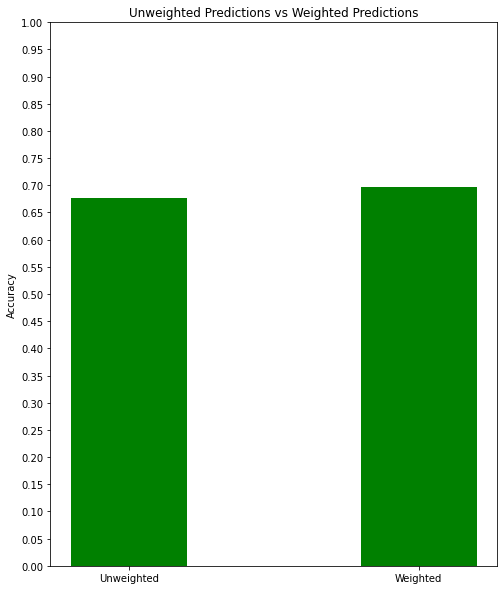

In [ ]:
# YOUR CODE HERE

data = {'Unweighted': token_accuracy, 'Weighted': magnitude_accuracy}

accs = list(data.keys())
methods = list(data.values())
fig = plt.figure(figsize = (8, 10))
 
plt.bar(accs, methods, color ='green',width = 0.4)
plt.title("Unweighted Predictions vs Weighted Predictions")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1.01, step=0.05))
plt.show()

#### (Q1.4) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

By not taking document length into account, a longer review will naturally affect the threshold outcome a lot more than a shorter review. Because we use the numerical difference between positive and negative words in each document, it's easier t ohave larger differences in longer documents. 

To solve this problem and have any review count the same towards the threshold computation, we can divide every document difference with its length. This way we obtain an average difference per word for this document. We sum all average differences together to obtain our sum. After that, we can add all document lengths together and divide by document number to obtain a document average length.

The threshold is calculated by multiplying our sum with the average document length and dividing by document number.

In [ ]:
# YOUR CODE HERE
#calculating the threshold
sum=0
lens=[]
for review in reviews:
    possum=0
    negsum=0
    words = 0
    for sentence in review["content"]:
        for token, pos_tag in sentence:
            token = token.lower()
            words += 1
            if token in lexicon_dict.keys():
                if lexicon_dict[token] > 0:
                    possum += lexicon_dict[token]
                else:
                    negsum += (-lexicon_dict[token])
    
    #Add average diffeence per word for each document
    sum += ((possum-negsum) / words)
    lens.append(words)

#average document length
avg_len = np.sum(lens) / len(lens)

#final threshold
threshold = (sum * avg_len) / len(reviews)    
threshold = int(threshold) + 1

print("New threshold is " + str(threshold))

#predict
for review in reviews:
    sum=0
    for sentence in review["content"]:
        for token, pos_tag in sentence:
            token = token.lower()
            if token in lexicon_dict.keys():
                s = lexicon_dict[token]
            else:
                s = 0
            sum += s
        
    if sum > threshold:
        prediction = 'POS'
    else:
        prediction ='NEG'

    if prediction == review["sentiment"]:
        magnitude_results.append(1)
    else:
        magnitude_results.append(0)


magnitude_accuracy = magnitude_results.count(1) / len(magnitude_results)
print("Accuracy: %0.2f" % magnitude_accuracy)


New threshold is 11
Accuracy: 0.70


# (2) Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes**.  What would be the problem instead with skipping words only for one class in case 2? 

By skipping words only for one class, we use words that only affect one of the two conditional probablilities. This means that more words affect predictions towards one class than the other, unfairly increasing the scores for this class every time such a word occurs. To make fair predictions, we need the conditional probability to be affected by the same words for each class.

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [ ]:
# YOUR CODE HERE

#computes the number each word occurs for every class 
def class_frequencies(trainset):
    """
    Computes the number each word occurs for every class for the given dataset

    Args:
      trainset: the dataset in which we want to compute the frequencies
    Returns:
      pos_freq: the frequency for the positive class
      neg_freq: the frequency for the negative class
    """
    pos_freq = {}
    neg_freq = {}

    for bag in trainset['pos']:
        for token, v in bag.items():
            if token in pos_freq.keys():
                pos_freq[token] += v
            else:
                pos_freq[token] = v

    for bag in trainset['neg']:
        for token, v in bag.items():
            if token in neg_freq.keys():
                neg_freq[token] += v
            else:
                neg_freq[token] = v


    return pos_freq, neg_freq

#returns the dataset vocabulary
def compute_vocab(documents):
    """
    Computes the vocabulary for the given dataset

    Args:
      documents: the input dataset from which we want to extract the vocabulary
    Returns:
      pos_freq: the frequency for the positive class
      neg_freq: the frequency for the negative class
    """
    vocab = set()
    for document in documents['pos']:  
        vocab.update(set(document.keys()))
    for document in documents['neg']:  
        vocab.update(set(document.keys()))
    return vocab

#number of documents for each class
def class_counts(docs):
    """
    Computes the number of reviews for each class

    Args:
      docs: the input data, from which we will determine the number 
      of positive and negative reviews
    Returns:
      pos: the number of positive reviews
      neg: the number of negative reviews
    """
    neg = len(docs['pos'])
    pos = len(docs['neg'])
    return pos, neg

def clear_dicts(c1, c2):
    """
    Deletes the words from frequencies that do not exist in both classes

    Args:
      c1: dictionary of words for the first class
      c2: dictionary of words for the second class
    Returns:
      new_c1: updated dictionary of the remaining words for the first class
      new_c2: updated dictionary of the remaining words for the second class
    """
    keys1 = c1.keys()
    keys2 = c2.keys()

    new_c1 = {} 
    new_c2 = {}

    for word in keys1:
        if word in keys2:
            new_c1[word] = c1[word]

    for word in keys2:
        if word in keys1:
            new_c2[word] = c2[word]

    return new_c1, new_c2

def train_nb(trainset):
    """
    Performs the training of the NB classifier by computing the trainset vocabulary,
    computing the class frequencies, keeping the words that appear in both classes with the 
    already implemented functions and then computes the priors and the importance of a word in class.

    Args:
      trainset: the dataset that we want to train the NB classifier with
    Returns:
      v: the trainset vocabulary
      priors: the priors
      conditionals: the conditionals
    """

    #compute trainset vocabulary
    v = compute_vocab(trainset)
    
    #compute class frequencies
    pos_f, neg_f = class_frequencies(trainset)
    
    #keep only words that appear in both classes
    pos_f, neg_f = clear_dicts(pos_f, neg_f)
    
    # compute priors
    pos_n, neg_n = class_counts(trainset)
    n = len(trainset['pos']) + len(trainset['neg'])
    priors = {'pos': pos_n/n, 'neg' : neg_n/n}
    
    pos_sum=0
    neg_sum=0

    for freq in pos_f.values():
        pos_sum += freq
    for freq in neg_f.values():    
        neg_sum += freq
    
    conditionals = {}
  
    #compute importance of word in class
    for t in v:
        pos_count = 0
        neg_count = 0
        if t in pos_f.keys():
            pos_count = pos_f[t]
        if t in neg_f.keys():
            neg_count = neg_f[t]

        # pos_cond = (pos_count+1) / pos_sum
        # neg_cond = (neg_count+1) / neg_sum

        pos_cond = (pos_count) / pos_sum
        neg_cond = (neg_count) / neg_sum

        conditionals[t] = (pos_cond,neg_cond)    
    
    
    return v, priors, conditionals


def test_nb(testset, priors, conditionals):
    """
    Performs the testing of the NB classifier

    Args:
      testset: the dataset that we want to test the NB classifier with
      priors: the priors (estimated before)
      conditionals: the conditionals (estimated before)
    Returns:
      nb_accuracy : the accuracy of the NB classifier in the test dataset
    """
    predictions = []
    tests = testset['pos'] + testset['neg']

    for document in testset['pos']:
        pos_score = np.log(priors['pos'])
        neg_score = np.log(priors['neg'])

        for token in document.keys():
            if token in conditionals.keys():
                if conditionals[token][0] > 0 and conditionals[token][1] > 0:
                    pos_score += document[token] * np.log(conditionals[token][0])
                    neg_score += document[token] * np.log(conditionals[token][1])

        if pos_score > neg_score:
            predictions.append(1)
        else:
            predictions.append(0)
    
    
    for document in testset['neg']:
        pos_score = np.log(priors['pos'])
        neg_score = np.log(priors['neg'])

        for token in document.keys():
            if token in conditionals.keys():
                if conditionals[token][0] > 0 and conditionals[token][1] > 0:
                    pos_score += document[token] * np.log(conditionals[token][0])
                    neg_score += document[token] * np.log(conditionals[token][1])

        if pos_score <= neg_score:
            predictions.append(1)
        else:
            predictions.append(0)
    

    nb_accuracy = predictions.count(1) / len(predictions)
    print("Accuracy: %0.3f" % nb_accuracy)

    return nb_accuracy

data = {'pos':[], 'neg':[]}

for review in reviews:
    bag = {}
    for sentence in review["content"]:
        for token, pos_tag in sentence:
            token = token.lower()
            if token in bag.keys():
                bag[token] += 1
            else:
                bag[token] = 1
    if review['sentiment'] == 'POS':
        data['pos'].append(bag)
    else:
        data['neg'].append(bag)


trainset = {'pos':data['pos'][0:900], 'neg':data['neg'][0:900]}
testset = {'pos':data['pos'][900:1000], 'neg':data['neg'][900:1000]}

v, priors, conditionals = train_nb(trainset)
acc = test_nb(testset, priors, conditionals)



Accuracy: 0.835


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

Accuracy is not a good metric if the classes are not balanced. If 90% of our data are positive, the priors for each class would be 0,9 and 0,1, which makes the classifier biased towards the positive class. Accuracy goes up if our model predicts (almost) all reviews to be positive, even though this does not generalize to a case with a good class distribution.

In our example below, we get almost a 90% accuracy, because our classifier predicts almost everything as a positive review and, in most cases, is correct.

In [ ]:
# YOUR CODE HERE


new_trainset = {'pos':data['pos'][0:900], 'neg':data['neg'][0:90]}
new_testset = {'pos':data['pos'][900:1000], 'neg':data['neg'][900:910]}


v, priors, conditionals = train_nb(new_trainset)
acc = test_nb(new_testset, priors, conditionals)

Accuracy: 0.891


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [ ]:
# YOUR CODE HERE

def train_nb(trainset):
    """
    Performs the training of the NB classifier by computing the trainset vocabulary,
    computing the class frequencies, keeping the words that appear in both classes with the 
    already implemented functions and then computes the priors and the importance of a word in class.
    This time it's implemented using laplace smoothing to distribute some "extra" probability to unseen words.

    Args:
      trainset: the dataset that we want to train the NB classifier with
    Returns:
      v: the trainset vocabulary
      priors: the priors
      conditionals: the conditionals
    """
    #compute trainset vocabulary
    v = compute_vocab(trainset)
    #compute class frequencies
    pos_f, neg_f = class_frequencies(trainset)
    
    #keep only words that appear in both classes
    pos_f, neg_f = clear_dicts(pos_f, neg_f)
    
    # compute priors
    pos_n, neg_n = class_counts(trainset)
    n = len(trainset['pos']) + len(trainset['neg'])
    priors = {'pos': pos_n/n, 'neg' : neg_n/n}

    pos_sum=0
    neg_sum=0

    #smoothing
    for freq in pos_f.values():
        pos_sum += (freq+1)
    for freq in neg_f.values():    
        neg_sum += (freq+1)


    conditionals = {}
    #compute importance of word in class
    for t in v:
        pos_count = 0
        neg_count = 0
        if t in pos_f.keys():
            pos_count = pos_f[t]
        if t in neg_f.keys():
            neg_count = neg_f[t]

        #smoothing: add +1 to each count
        pos_cond = (pos_count+1) / pos_sum
        neg_cond = (neg_count+1) / neg_sum


        conditionals[t] = (pos_cond,neg_cond)   
    
    return v, priors, conditionals


v, priors, conditionals = train_nb(trainset)
acc = test_nb(testset, priors, conditionals)


Accuracy: 0.830


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [ ]:
# YOUR CODE HERE
k=10

def rrsplit(data=data, k=10):
    """
    Performs the round robin splitting method and calls the train_nb and test_nb
    function to do the cross validation 

    Args:
      data: data
      k = 10: the number of the folds of the cross validation
    Returns:
      accuracies: a list contatining the accuracy of the classifier for each fold
      vocab_size: the length of the vocabulary (for question 2.8)
    """
    folds = [ {'pos':[], 'neg':[]} for index in range(k) ]

    vocab_size = []
    accuracies = []
    for i in range(len(data['pos'])):
        idx = i % k
        folds[idx]['pos'].append(data['pos'][i])
        folds[idx]['neg'].append(data['neg'][i])


    for i in range(k):
        testset = folds[i]
        trainset = {'pos':[], 'neg':[]}
        for j in range(k):
            if i != j:
                trainset['pos'] += folds[j]['pos']
                trainset['neg'] += folds[j]['neg']
        
        v, priors, conditionals = train_nb(trainset)
        acc = test_nb(testset, priors, conditionals)
        accuracies.append(acc)
        vocab_size.append(len(v))
        
    # print("Mean Accuracy: %0.2f" % sum(accuracies) / k)
    return accuracies, vocab_size

accuracies, vocab_size = rrsplit(data)


Accuracy: 0.775
Accuracy: 0.840
Accuracy: 0.815
Accuracy: 0.870
Accuracy: 0.785
Accuracy: 0.860
Accuracy: 0.810
Accuracy: 0.785
Accuracy: 0.830
Accuracy: 0.810


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).** Note: you're not allowed to use a library for computing the variance. 

In [ ]:
# YOUR CODE HERE

def get_mean(data):
    """
    Computes the mean of the data given 

    Args:
      data: the data, from which we want to compute the mean
    Returns:
      mean: the mean of the data
    """
    N = len(data)
    sum = 0
    for i in range(N):
        sum += data[i]
    mean = sum/N
    return mean

def get_variance(data):
    """
    Computes the variance of the data given 

    Args:
      data: the data, from which we want to compute the variance
    Returns:
      variance: the variance of the data
    """
    M = len(data)
    s = 0
    m = get_mean(data)
    for j in range(M):
        s += (data[j]-m)**2
    var = s/M
    return var


mean = get_mean(accuracies)
var = get_variance(accuracies)
print("The mean of the 10 accuracy scores is",mean ,"and the variance is %0.5f" %var)

The mean of the 10 accuracy scores is 0.8180000000000002 and the variance is 0.00093


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [ ]:
# YOUR CODE HERE

data_stem = {'pos':[], 'neg':[]}
stemmer = PorterStemmer()

for review in reviews:
    bag = {}
    for sentence in review["content"]:
        for token, pos_tag in sentence:
            # token = use stemming on each token while parsing the data
            token = stemmer.stem(token.lower())
            if token in bag.keys():
                bag[token] += 1
            else:
                bag[token] = 1
    if review['sentiment'] == 'POS':
        data_stem['pos'].append(bag)
    else:
        data_stem['neg'].append(bag)


trainset_stem = {'pos':data_stem['pos'][0:900], 'neg':data_stem['neg'][0:900]}
testset_stem = {'pos':data_stem['pos'][900:1000], 'neg':data_stem['neg'][900:1000]}

# v, priors, conditionals = train_nb(trainset_stem)
# acc = test_nb(testset_stem, priors, conditionals)


#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier. 


In [ ]:
# YOUR ANSWER HERE
accuracies, vocab_size_stemmer = rrsplit(data_stem)
mean = get_mean(accuracies)
var = get_variance(accuracies)
print("The mean of the 10 accuracy scores is",mean ,"and the variance is %0.5f" %var)

Accuracy: 0.765
Accuracy: 0.835
Accuracy: 0.805
Accuracy: 0.875
Accuracy: 0.790
Accuracy: 0.845
Accuracy: 0.820
Accuracy: 0.790
Accuracy: 0.825
Accuracy: 0.810
The mean of the 10 accuracy scores is 0.8160000000000001 and the variance is 0.00089


#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [ ]:
"""
A simple for loop to compare how Stemmer affects the vocabulary size
"""

print("Vocabulary size with the use of Stemmer :", vocab_size_stemmer, "vs without using Stemmer :" ,vocab_size)

#for i in range(len(vocab_size_stemmer)):
#    print("Vocabulary size with the use of Stemmer ( fold",i,") :", vocab_size_stemmer[i], "vs without using Stemmer :" ,vocab_size[i])

Vocabulary size with the use of Stemmer : [32371, 32482, 32545, 32498, 32699, 32439, 32440, 32493, 32576, 32667] vs without using Stemmer : [45329, 45392, 45438, 45389, 45648, 45296, 45365, 45409, 45557, 45642]


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features. 






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [ ]:
# YOUR CODE HERE

# tri = True
# tri = False

def build_ngrams(tri = False):
    """
    Computes the bag of words containing bigrams and trigrams according to the input arguement. 

    Args:
      tri: Boolean, if true then this function computes the BoW containing unigrams+bigrams+trigrams,
      else if it is false, the BoW will consist only of unigrams+bigrams
    Returns:
      data_ngrams: the data that contain the unigrams+bigrams(+trigrams) and the sentiment of the review
    """
    
    data_ngrams = {'pos':[], 'neg':[]}

    for review in reviews:
        bag = {}
        unigrams = []
        for sentence in review["content"]:
            for token, pos_tag in sentence:
                token = token.lower()
                unigrams.append(token)
                if token in bag.keys():
                    bag[token] += 1
                else:
                    bag[token] = 1

        bigrams = [' '.join(e) for e in ngrams(unigrams,2)]
        for token in bigrams:
            if token in bag.keys():
                bag[token] += 1
            else:
                bag[token] = 1

        if tri:
            trigrams = [' '.join(e) for e in ngrams(unigrams,3)]
            for token in trigrams:
                if token in bag.keys():
                    bag[token] += 1
                else:
                    bag[token] = 1


        if review['sentiment'] == 'POS':
            data_ngrams['pos'].append(bag)
        else:
            data_ngrams['neg'].append(bag)

    return data_ngrams


# trainset_ngrams = {'pos':data_ngrams['pos'][0:900], 'neg':data_ngrams['neg'][0:900]}
# testset_ngrams = {'pos':data_ngrams['pos'][900:1000], 'neg':data_ngrams['neg'][900:1000]}

# v, priors, conditionals = train_nb(trainset_ngrams)
# acc = test_nb(testset_ngrams, priors, conditionals)



data_ngrams = build_ngrams(False)
accuracies, vocab_sizes1 = rrsplit(data_ngrams)
mean = get_mean(accuracies)
var = get_variance(accuracies)
print("The mean of the 10 accuracy scores for unigrams + bigrams is",mean ,"and the variance is %0.5f" %var)

data_ngrams = build_ngrams(True)
accuracies, vocab_sizes2 = rrsplit(data_ngrams)
mean = get_mean(accuracies)
var = get_variance(accuracies)
print("The mean of the 10 accuracy scores for unigrams + bigrams + trigrams is",mean ,"and the variance is %0.5f" %var)


Accuracy: 0.790
Accuracy: 0.835
Accuracy: 0.805
Accuracy: 0.885
Accuracy: 0.800
Accuracy: 0.860
Accuracy: 0.830
Accuracy: 0.835
Accuracy: 0.830
Accuracy: 0.830
The mean of the 10 accuracy scores for unigrams + bigrams is 0.8300000000000001 and the variance is 0.00071
Accuracy: 0.780
Accuracy: 0.870
Accuracy: 0.815
Accuracy: 0.880
Accuracy: 0.810
Accuracy: 0.870
Accuracy: 0.835
Accuracy: 0.845
Accuracy: 0.840
Accuracy: 0.830
The mean of the 10 accuracy scores for unigrams + bigrams + trigrams is 0.8374999999999998 and the variance is 0.00086



#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


*Write your answer here.*

We see that when we are using unigrams+bigrams, the size of the vocabulary is 471032. If we use unigrams+bigrams+trigrams, the size of the vocabulary is 1416686. The difference in the size between the two cases is 945654, meaning the vocabulary in the second case is approximately 3 times bigger than the one in the first case. So we expect that the vocabulary size will increase even more if we use ngrams with n >= 3.

In [ ]:
data_ngrams = build_ngrams(False)
trainset_ngrams = {'pos':data_ngrams['pos'][0:900], 'neg':data_ngrams['neg'][0:900]}
testset_ngrams = {'pos':data_ngrams['pos'][900:1000], 'neg':data_ngrams['neg'][900:1000]}
v, priors, conditionals = train_nb(trainset_ngrams)
acc = test_nb(testset_ngrams, priors, conditionals)
#print(len(v), acc)
print("The vocab size using unigrams+bigrams is " ,len(v))

data_ngrams = build_ngrams(True)
trainset_ngrams = {'pos':data_ngrams['pos'][0:900], 'neg':data_ngrams['neg'][0:900]}
testset_ngrams = {'pos':data_ngrams['pos'][900:1000], 'neg':data_ngrams['neg'][900:1000]}
v, priors, conditionals = train_nb(trainset_ngrams)
acc = test_nb(testset_ngrams, priors, conditionals)
#print(len(v), acc)
print("The vocab size using unigrams+bigrams+trigrams is " ,len(v))


Accuracy: 0.845
The vocab size using unigrams+bigrams is  471032
Accuracy: 0.835
The vocab size using unigrams+bigrams+trigrams is  1416686


# (3) Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [ ]:
# YOUR CODE HERE
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
import scipy
from scipy import sparse
import pandas as pd

def feature_extraction(documents,POS):
    """
    This function creates the feature vector for the SVM. 
    The data are read and the count of every word for each document is saved. 
    Then, the labels are put into a numpy vector. 1 for positive and 0 for negative.
    The feature vector returned is a docs X words matrix containing the count for each word in each document
    and 0 if the word doesn't exist
    Args:
      documents: the reviews to be taken into consideration for the creation of the features vectors
      POS: Flag to determine if we need to take pos_tags into accoutn as well
    Returns:
      x_vect, y: feature vector, labels
    """

    data = {'pos':[], 'neg':[]}

    for review in documents:
        bag = {}
        for sentence in review["content"]:
            for token, pos_tag in sentence:
                token = token.lower()
                if POS:
                    token = token + '_' + pos_tag
                if token in bag.keys():
                    bag[token] += 1
                else:
                    bag[token] = 1
        if review['sentiment'] == 'POS':
            data['pos'].append(bag)
        else:
            data['neg'].append(bag)

    one = np.ones(len(data['pos']))
    zero = np.zeros(len(data['neg']))
    y = np.concatenate((one,zero))
    len_docs = len(y)

    v = compute_vocab(data)
    len_v = len(v)

    x_vect = np.zeros((len_docs, len_v))

    data_l = data['neg'] + data['pos']

    #build feature vector
    for i in range(len_docs):
        for j, word in enumerate(v):
            if word in data_l[i].keys():
                x_vect[i][j] = data_l[i][word]

    return x_vect,y

    
X,Y = feature_extraction(reviews,False)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state=42)

clf = LinearSVC(max_iter=10000)
clf.fit(X_train,y_train)

print('The accuracy of the SVM is : %0.2f' %clf.score(X_test,y_test))

cvaccuracy = cross_val_score(clf, X_train, y_train, cv=10)
for i in range(len(cvaccuracy)):
    print('Model accuracy ( fold',i+1,') : %0.2f' %cvaccuracy[i])
meanacc = get_mean(cvaccuracy)
varacc = get_variance(accuracies)
print("The mean of the 10 accuracy scores is %0.2f" %meanacc ,"and the variance is %0.5f" %varacc)

The accuracy of the SVM is : 0.83
Model accuracy ( fold 0 ) : 0.76
Model accuracy ( fold 1 ) : 0.85
Model accuracy ( fold 2 ) : 0.88
Model accuracy ( fold 3 ) : 0.86
Model accuracy ( fold 4 ) : 0.87
Model accuracy ( fold 5 ) : 0.80
Model accuracy ( fold 6 ) : 0.82
Model accuracy ( fold 7 ) : 0.89
Model accuracy ( fold 8 ) : 0.82
Model accuracy ( fold 9 ) : 0.83
The mean of the 10 accuracy scores is 0.84 and the variance is 0.00071


In [ ]:
# YOUR CODE HERE
k=10

def rrsplit_svm(reviews, k=10):

    folds = [ {'pos':[], 'neg':[]} for index in range(k) ]

    vocab_size = []
    accuracies = []
    for i in range(len(data['pos'])):
        idx = i % k
        folds[idx]['pos'].append(data['pos'][i])
        folds[idx]['neg'].append(data['neg'][i])


    for i in range(k):
        testset = folds[i]
        trainset = {'pos':[], 'neg':[]}
        for j in range(k):
            if i != j:
                trainset['pos'] += folds[j]['pos']
                trainset['neg'] += folds[j]['neg']
        


        X_train,Y_train = feature_extraction(trainset,False)
        X_test, Y_test = feature_extraction(testset,False)
    
        clf = LinearSVC(max_iter=10000)
        clf.fit(X_train,X_train)
        cvaccuracy = cross_val_score(clf, X_test, Y_test, cv=10)
        print(cvaccuracy)

        
    # print("Mean Accuracy: %0.2f" % sum(accuracies) / k)
    
rrsplit_svm(reviews)


### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [ ]:
# YOUR CODE HERE

# def feature_extraction(documents,POS):

#     y = np.empty(len(documents))

#     for i,d in enumerate(documents):
#         if documents[i]['sentiment'] == 'POS':
#             y[i] = 1
#         elif documents[i]['sentiment'] == 'NEG':
#             y[i] = 0

#     cv = CountVectorizer(lowercase=False)

#     revs = pd.DataFrame(documents)
#     revs['content'] = revs['content'].apply(clean_text,pos=POS)
#     x = revs[['content']]
#     x_vect = cv.fit_transform(x['content'])

#     return x_vect,y
    
X,Y = feature_extraction(reviews,True)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state=42)

clf = LinearSVC(max_iter=10000)
clf.fit(X_train,y_train)

print('The accuracy of the SVM is : %0.2f' %clf.score(X_test,y_test))

cvaccuracypos = cross_val_score(clf, X_train, y_train, cv=10)
for i in range(len(cvaccuracypos)):
    print('Model accuracy ( fold',i+1,') : %0.2f' %cvaccuracypos[i])
meanaccpos = get_mean(cvaccuracypos)
varaccpos = get_variance(cvaccuracypos)
print("The mean of the 10 accuracy scores is %0.2f" %meanaccpos ,"and the variance is %0.5f" %varaccpos)

The accuracy of the SVM is : 0.83
Model accuracy ( fold 0 ) : 0.79
Model accuracy ( fold 1 ) : 0.83
Model accuracy ( fold 2 ) : 0.88
Model accuracy ( fold 3 ) : 0.85
Model accuracy ( fold 4 ) : 0.84
Model accuracy ( fold 5 ) : 0.79
Model accuracy ( fold 6 ) : 0.84
Model accuracy ( fold 7 ) : 0.91
Model accuracy ( fold 8 ) : 0.79
Model accuracy ( fold 9 ) : 0.86
The mean of the 10 accuracy scores is 0.84 and the variance is 0.00139


*Write your answer here.*

As we can see from the cross validation, the average accuracy is only 1% higher when we take into consideration the pos tags. Since the difference is relatively non-existent, we might as well prefer the first case where we do not use the pos tags, as long as they do not contribute to our model reaching a much higher accuracy, while making the whole process more computationally expensive by adding more commands.

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [ ]:
# YOUR CODE HERE

def open_feature_extraction(documents):
    """
    Works the same way as feature_extraction, but throws away every token that is a closed-class word
    Args:
      documents: the reviews to be taken into consideration for the creation of the features vectors
    Returns:
      x_vect, y: feature vector, labels
    """
    
    data = {'pos':[], 'neg':[]}

    for review in documents:
        bag = {}
        for sentence in review["content"]:
            for token, pos_tag in sentence:
                #Only keep open-class words 
                if pos_tag.startswith('NN') or pos_tag.startswith('VB') or pos_tag.startswith('JJ') or pos_tag.startswith('RB'):
                    token = token.lower() + '_' + pos_tag
                    
                    if token in bag.keys():
                        bag[token] += 1
                    else:
                        bag[token] = 1
        if review['sentiment'] == 'POS':
            data['pos'].append(bag)
        else:
            data['neg'].append(bag)

    one = np.ones(len(data['pos']))
    zero = np.zeros(len(data['neg']))
    y = np.concatenate((one,zero))
    len_docs = len(y)

    v = compute_vocab(data)
    len_v = len(v)

    x_vect = np.zeros((len_docs, len_v))

    data_l = data['neg'] + data['pos']

    #build feature vector
    for i in range(len_docs):
        for j, word in enumerate(v):
            if word in data_l[i].keys():
                x_vect[i][j] = data_l[i][word]

    # print(x_vect.shape)
    # print(y.shape)

    return x_vect,y

    
X,Y = open_feature_extraction(reviews)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state=52)

clf = LinearSVC(max_iter=10000)
clf.fit(X_train,y_train)

print('The accuracy of the SVM is : %0.2f' %clf.score(X_test,y_test))

cvaccuracy_openclass = cross_val_score(clf, X_train, y_train, cv=10)
for i in range(len(cvaccuracy_openclass)):
    print('Model accuracy ( fold',i+1,') : %0.2f' %cvaccuracy_openclass[i])
meanacc_openpos = get_mean(cvaccuracy_openclass)
varacc_openpos = get_variance(cvaccuracy_openclass)
print("The mean of the 10 accuracy scores is %0.2f" %meanacc_openpos ,"and the variance is %0.5f" %varacc_openpos)

The accuracy of the SVM is : 0.82
Model accuracy ( fold 0 ) : 0.86
Model accuracy ( fold 1 ) : 0.84
Model accuracy ( fold 2 ) : 0.81
Model accuracy ( fold 3 ) : 0.83
Model accuracy ( fold 4 ) : 0.87
Model accuracy ( fold 5 ) : 0.85
Model accuracy ( fold 6 ) : 0.85
Model accuracy ( fold 7 ) : 0.90
Model accuracy ( fold 8 ) : 0.84
Model accuracy ( fold 9 ) : 0.83
The mean of the 10 accuracy scores is 0.85 and the variance is 0.00053


*Write your answer here.*

The accuracy of this case where we discard closed-class words is approximately the same as in the question above. This means that the open-class words are more beneficial for our model's training and make it able to reach an acceptable accuracy. This was expected, because if we assume a review contains the verb "like" many times, which is an open-class word, then it reveals the reviewer's positive feelings for the movie. Since these words are the ones who matter the most, we can discard the closed-class words.

# (Q4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


In this notebook, several approaches were followed in order to classify movie reviews.

To begin with, we implemented a lexicon approach, where according to the polarity of the words of the review's content, we made a decision about the review. After incorporating the magnitude of the words, we managed to increase the accuracy from 0.68 to 0.70. This was a very simple approach, so the results taken were expected to not be great.

Our next approach was the implementation of the Naive Bayes classifier. The model performed better than the lexicon approach, reaching up to 0.83 accuracy on the given test set. After that, we followed several techniques such as smoothing to "give" some extra probability to unseen words. This allowed us to not throw them away, giving us more data to work with. We also used stemming to simplify the vocabulary, but the unstemmed approach performed marginally better. Furthermore, we implemented the n-gram models to test their accuracies. However, even the aforementioned models are not able to deal with long-distance dependencies that might occur in the reviews and that poses a limit to the model's ability to reach even higher accuracy. In addition to that, when we are using the uni+bi+trigram model, then the vocabulary becomes massive. In cases where the vocabulary is small this won't have any major effect, but in other cases the curse dimensionality problem comes up.


The final implementation included a SVM to classify the reviews. The SVM performed better than the NB classifier, but the difference was not significant. However, after introducing POS-tags, we observed a minor improvement in accuracy. This makes sense, since we had more features to work with. The next step was about keeping only open-class words, because these are the ones that express the real feelings of the reviewer about the movie. This made our model perform a little bit better, reaching up to 0.85, which was the highest of all our approaches. 


Nevertheless, it has to be mentioned that the input of the SVM was a matrix of shape (len(reviews),len(vocabulary)), which in some other cases can be massive. Having to deal with such dimensionalities can be very computationally expensive, which poses some limits to the SVM. That's why sparse matrices have to be used to compress the information of the matrix, as it was used in our implementation.


# Submission 


In [ ]:
# Write your names and student numbers here:
# Nick Apostolikas #14343231
# Orestis Gorgogiannis #14480778

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group. 